## **REPO**

In [180]:
!git clone https://github.com/duy-nq/Stocks-Prediction.git

fatal: destination path 'Stocks-Prediction' already exists and is not an empty directory.


## **IMPORT LIBRARIES**

In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

import seaborn as sns

from datetime import datetime as dt
from datetime import date

## **FUNCTIONS**

In [182]:
def split_and_remove(df: pd.DataFrame):
  df['Date'] = df['Date/Time'].apply(lambda date_time: dt.strptime(date_time, '%m/%d/%Y %H:%M').date())

  return df

In [183]:
def groupped_df(df: pd.DataFrame):
  return df.groupby('Date').agg(
    Open=('Open', 'first'),
    High=('High', 'max'),
    Low=('Low', 'min'),
    Close=('Close', 'last'),
    Volume=('Volume', 'sum')
  ).sort_values(by='Date')

In [184]:
def outlier_check(df: pd.DataFrame, att: str):
  Q1 = df[att].quantile(0.25)
  Q3 = df[att].quantile(0.75)
  IQR = Q3 - Q1

  outliers = df[(df[att] < (Q1 - 1.5 * IQR)) | (df[att] > (Q3 + 1.5 * IQR))]
  print("Outliers based on IQR:")
  print(outliers)


In [185]:
def basic_train(models, X_train, y_train, is_plot: bool):
    def plot():
        train_score = pd.DataFrame(data = training_score, columns = ['MAE'])
        train_score.index = ['ELAS', 'RF', 'AB']
        train_score = train_score.sort_values(by = 'MAE')

        plt.figure(figsize=(15, 5))
        sns.barplot(x=train_score.index, y='MAE', data=train_score,palette="rocket")
        plt.xlabel('Models')
        plt.ylabel('MAE')
        plt.title('MAE vs Models')

    training_score = []
    for model in models:
        model.fit(X_train,y_train)
        y_pred_train = model.predict(X_train)
        train_mse = mean_absolute_error(y_train, y_pred_train)
        training_score.append(train_mse)

    if is_plot:
        plot()

    return models

In [186]:
def gs_train(models, X_train, y_train, is_plot: bool):
    def grid_search_cv(model, params):
        kfold = KFold(n_splits=5, shuffle=True, random_state=23)
        global best_params, best_score

        grid_search = RandomizedSearchCV(
            estimator = model,
            param_distributions=params,
            verbose=1,
            n_iter=5,
            random_state=23,
            cv=kfold,
            scoring='neg_mean_absolute_error',
            n_jobs = -1
        )

        grid_search.fit(X_train, y_train)
        best_params = grid_search.best_params_
        best_score = (np.round(grid_search.best_score_, 5))

        return best_params, best_score

    def plot():
        optimized_scores = pd.DataFrame({'Optimized Scores':[elas_best_score, rf_best_score,ab_best_score] })
        optimized_scores.index = ['ELAS', 'Random Forest', 'Ada Boost']
        optimized_scores = optimized_scores.sort_values(by = 'Optimized Scores')
        optimized_scores
        plt.figure(figsize=(15, 5))
        sns.barplot(x=optimized_scores.index, y='Optimized Scores', data=optimized_scores,palette="rocket")
        plt.xlabel('Models')
        plt.ylabel('MAE')
        plt.title('Optimized_MAE vs models')
        plt.show()

    elas_best_params, elas_best_score = grid_search_cv(models[1], ELASTIC_PARAMS)
    rf_best_params, rf_best_score = grid_search_cv(models[2], RF_PARAMS)
    ab_best_params, ab_best_score = grid_search_cv(models[3], AB_PARAMS)

    if is_plot:
        plot()

    opt_model = [
        ElasticNet(**elas_best_params),
        RandomForestRegressor(**rf_best_params),
        AdaBoostRegressor(**ab_best_params)
    ]

    return opt_model

In [187]:
def plot_result(test_list, pred_list: list[float]):
    plt.figure(figsize=(10, 6))

    plt.plot(test_list, label='Thực tế', color='blue')
    plt.plot(pred_list, label='Dự đoán', color='red', linestyle='dashed')

    plt.title('So sánh giá cổ phiếu trên thực tế và dự đoán')
    plt.xlabel('Ngày')
    plt.ylabel('Giá (nghìn VNĐ)')
    plt.legend()
    plt.show()

In [188]:
def one_day_prediction(model, data):
  results = []
  for i in range(3, len(data)):
    model_input = np.array([data[i][0], sum(data[i-3:i][1])/3, sum(data[i-3:i][2])/3])
    pred = model.predict(model_input.reshape(1, -1))
    results.append(pred)

  return results

## **DATA PREPROCESSING**

### **Load data**

In [189]:
fpt_data = pd.read_csv('/content/Stocks-Prediction/FPT.csv')
msn_data = pd.read_csv('/content/Stocks-Prediction/MSN.csv')
pnj_data = pd.read_csv('/content/Stocks-Prediction/PNJ.csv')
vic_data = pd.read_csv('/content/Stocks-Prediction/VIC.csv')

### **Kiểm tra các giá trị null**

Trước khi loại bỏ các giá trị null

In [190]:
fpt_data.shape, msn_data.shape, pnj_data.shape, vic_data.shape

((97406, 8), (135354, 8), (125309, 8), (101266, 8))

Loại bỏ các dòng dữ liệu có chứa giá trị null

In [191]:
fpt_data.dropna(axis=0), msn_data.dropna(axis=0), pnj_data.dropna(axis=0), vic_data.dropna(axis=0)

(      Ticker         Date/Time   Open   High    Low  Close  Volume  \
 0        FPT   12/25/2018 9:15  30.89  30.89  30.89  30.89   35410   
 1        FPT   12/25/2018 9:16  30.81  30.81  30.81  30.81     190   
 2        FPT   12/25/2018 9:17  30.74  30.81  30.74  30.74    1120   
 3        FPT   12/25/2018 9:18  30.74  30.74  30.74  30.74    2120   
 4        FPT   12/25/2018 9:19  30.74  30.74  30.74  30.74   22500   
 ...      ...               ...    ...    ...    ...    ...     ...   
 97401    FPT  12/22/2020 14:24  58.20  58.20  58.20  58.20   27470   
 97402    FPT  12/22/2020 14:25  58.20  58.20  58.20  58.20   14820   
 97403    FPT  12/22/2020 14:26  58.20  58.20  58.20  58.20     500   
 97404    FPT  12/22/2020 14:29  58.10  58.10  58.10  58.10    2500   
 97405    FPT  12/22/2020 14:46  58.10  58.10  58.10  58.10   11170   
 
        Open Interest  
 0                  0  
 1                  0  
 2                  0  
 3                  0  
 4                  0  
 .

Sau khi loại bỏ các giá trị null

In [192]:
fpt_data.shape, msn_data.shape, pnj_data.shape, vic_data.shape

((97406, 8), (135354, 8), (125309, 8), (101266, 8))

### **Loại bỏ các thuộc tính không cần thiết**

Kiểm tra các giá trị của thuộc tính Open Interest trong các dataset

In [193]:
fpt_data['Open Interest'].unique(), msn_data['Open Interest'].unique(), pnj_data['Open Interest'].unique(), vic_data['Open Interest'].unique()

(array([0]), array([0]), array([0]), array([0]))

Các thuộc tính *Ticker*, *Open Interest* sẽ bị loại bỏ do đều chứa các giá trị có tính "lặp lại" và không mang lại giá trị cho quá trình dự đoán

In [194]:
fpt_data = fpt_data.drop(['Ticker', 'Open Interest'], axis=1)
msn_data = msn_data.drop(['Ticker', 'Open Interest'], axis=1)
pnj_data = pnj_data.drop(['Ticker', 'Open Interest'], axis=1)
vic_data = vic_data.drop(['Ticker', 'Open Interest'], axis=1)

### **Tách Date/Time thành Date**

In [195]:
fpt_split = split_and_remove(fpt_data)
msn_split = split_and_remove(msn_data)
pnj_split = split_and_remove(pnj_data)
vic_split = split_and_remove(vic_data)

### **Chuyển dự liệu cổ phiếu theo phút về theo ngày**

In [196]:
grouped_fpt = groupped_df(fpt_split)
grouped_msn = groupped_df(msn_split)
grouped_pnj = groupped_df(pnj_split)
grouped_vic = groupped_df(vic_split)

In [197]:
grouped_fpt.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-12-25,30.89,30.89,30.59,30.66,84960
2018-12-26,31.04,31.22,30.89,30.89,333590
2018-12-27,31.41,31.52,31.19,31.19,454860
2018-12-28,31.34,31.49,31.19,31.49,387170
2019-01-02,31.19,31.45,30.70,30.74,459120


### **Ý tưởng**

Ở đây, thống nhất xây dựng một mô hình sử dụng các thuộc tính bao gồm *Open, High, Low* để dự đoán giá trị của *Close*.

Trên thực tế, trước mỗi phiên giao dịch chúng ta chỉ biết trước được giá trị của Open (thường là dựa vào *Close* của ngày hôm trước!). Như vậy, nhất thiết phải cần có một phương pháp để "tạm ước lượng" *High* và *Low* để làm input cho mô hình ở giai đoạn test!

Đơn giản nhất là sử dụng Moving Average để ước tính hai thông số này! Có thể xem xét sử dụng Linear Regression với input là các giá trị của một số (?) ngày trước đó.

### **Độ tương quan giữa các thuộc tính**

In [198]:
grouped_fpt.corr(), grouped_msn.corr(), grouped_pnj.corr(), grouped_vic.corr()

(            Open      High       Low     Close    Volume
 Open    1.000000  0.997772  0.998428  0.995735  0.435731
 High    0.997772  1.000000  0.997439  0.998020  0.465502
 Low     0.998428  0.997439  1.000000  0.997950  0.420534
 Close   0.995735  0.998020  0.997950  1.000000  0.442653
 Volume  0.435731  0.465502  0.420534  0.442653  1.000000,
             Open      High       Low     Close    Volume
 Open    1.000000  0.996786  0.997286  0.993677 -0.313134
 High    0.996786  1.000000  0.995732  0.997477 -0.285659
 Low     0.997286  0.995732  1.000000  0.996062 -0.334361
 Close   0.993677  0.997477  0.996062  1.000000 -0.297848
 Volume -0.313134 -0.285659 -0.334361 -0.297848  1.000000,
             Open      High       Low     Close    Volume
 Open    1.000000  0.992990  0.993992  0.986643 -0.212151
 High    0.992990  1.000000  0.992219  0.992959 -0.205463
 Low     0.993992  0.992219  1.000000  0.993224 -0.225731
 Close   0.986643  0.992959  0.993224  1.000000 -0.203914
 Volume -0.2

Dễ thấy, thuộc tính Volume giao động trong khoảng từ -0.30 đến 0.44, nếu so sánh với các thuộc tính khác thì quả thật có sự chênh lệch khá lớn. Vì vậy, Volume sẽ tạm thời bị loại bỏ khỏi quá trình huấn luyện.


In [199]:
grouped_fpt = grouped_fpt.drop(['Volume'], axis=1)
grouped_msn = grouped_msn.drop(['Volume'], axis=1)
grouped_pnj = grouped_pnj.drop(['Volume'], axis=1)
grouped_vic = grouped_vic.drop(['Volume'], axis=1)

### **Áp dụng RobustScaler**

Kiểm tra outliers của các dataset. Nhận thấy ở tất cả các bộ dataset và các thuộc tính hiện có, không xuất hiện phần tử ngoại lai làm ảnh hưởng đến quá trình scaling.

In [200]:
outlier_check(grouped_msn, 'Close')

Outliers based on IQR:
Empty DataFrame
Columns: [Open, High, Low, Close]
Index: []


Các bộ dataset khác nhau sẽ sử dụng những scaler khác nhau do miền dữ liệu giữa các thuộc tính trong các dataset là không đồng bộ.

In [201]:
fpt_scaler_x = RobustScaler()
fpt_scaler_y = RobustScaler()
msn_scaler_x = RobustScaler()
msn_scaler_y = RobustScaler()
pnj_scaler_x = RobustScaler()
pnj_scaler_y = RobustScaler()
vic_scaler_x = RobustScaler()
vic_scaler_y = RobustScaler()

### **Phân chia dữ liệu**

In [219]:
X_fpt = grouped_fpt.to_numpy()[:, :-1]
y_fpt = grouped_fpt.to_numpy()[:, -1].reshape(-1,1)

scaled_X_fpt = fpt_scaler_x.fit_transform(X_fpt)
scaled_y_fpt = fpt_scaler_y.fit_transform(y_fpt)

X_train_fpt, X_test_fpt, y_train_fpt, y_test_fpt = train_test_split(scaled_X_fpt, scaled_y_fpt, test_size=0.1, random_state=42)

In [220]:
X_msn = grouped_msn.to_numpy()[:, :-1]
y_msn = grouped_msn.to_numpy()[:, -1].reshape(-1,1)

scaled_X_msn = msn_scaler_x.fit_transform(X_msn)
scaled_y_msn = msn_scaler_y.fit_transform(y_msn)

X_train_msn, X_test_msn, y_train_msn, y_test_msn = train_test_split(scaled_X_msn, scaled_y_msn, test_size=0.1, random_state=42)

In [221]:
X_pnj = grouped_pnj.to_numpy()[:, :-1]
y_pnj = grouped_pnj.to_numpy()[:, -1].reshape(-1,1)

scaled_X_pnj = pnj_scaler_x.fit_transform(X_pnj)
scaled_y_pnj = pnj_scaler_y.fit_transform(y_pnj)

X_train_pnj, X_test_pnj, y_train_pnj, y_test_pnj = train_test_split(scaled_X_pnj, scaled_y_pnj, test_size=0.1, random_state=42)

In [222]:
X_vic = grouped_vic.to_numpy()[:, :-1]
y_vic = grouped_vic.to_numpy()[:, -1].reshape(-1,1)

scaled_X_vic = vic_scaler_x.fit_transform(X_vic)
scaled_y_vic = vic_scaler_y.fit_transform(y_vic)

X_train_vic, X_test_vic, y_train_vic, y_test_vic = train_test_split(scaled_X_vic, scaled_y_vic, test_size=0.1, random_state=42)

## **MODELLING**

### **Parameters**

In [122]:
ELASTIC_PARAMS = {
    'alpha': np.linspace(0.001, 15, 25),
    'l1_ratio': np.linspace(0.001, 0.999, 25),
    'random_state': [42]
}

RF_PARAMS = {
    'max_features':[2,3],
}

AB_PARAMS = {
    'learning_rate': np.linspace(0.001, 0.8, 25),
    'n_estimators': [50]
}

### **Mã cổ phiểu FPT**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

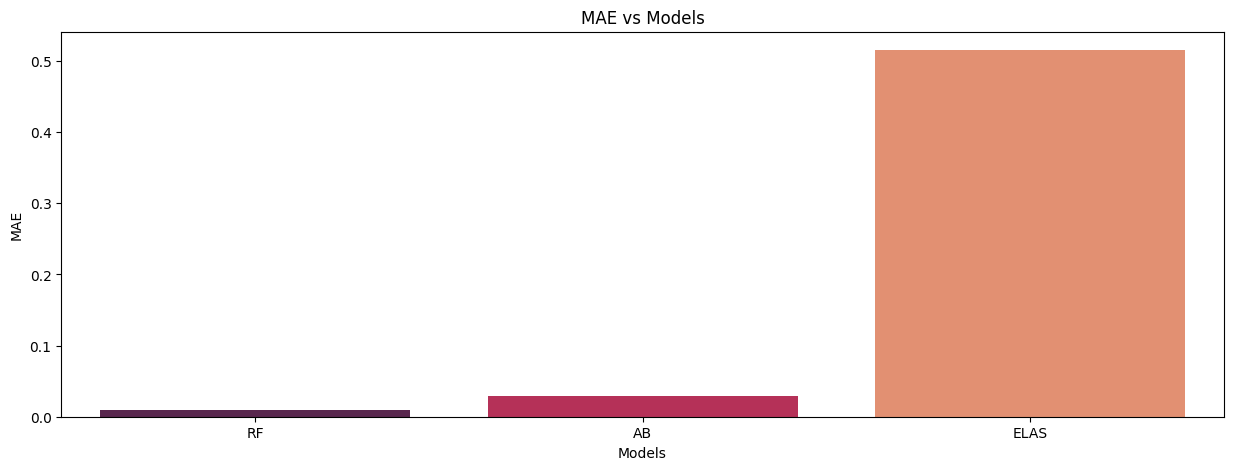

In [223]:
model_fpt = [
    ElasticNet(random_state=42),
    RandomForestRegressor(random_state=42),
    AdaBoostRegressor(random_state=42)
]

init_model_fpt = basic_train(model_fpt, X_train_fpt, y_train_fpt, False)
opt_model_fpt = basic_train(init_model_fpt, X_train_fpt, y_train_fpt, True)

### **Mã cổ phiểu MSN**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

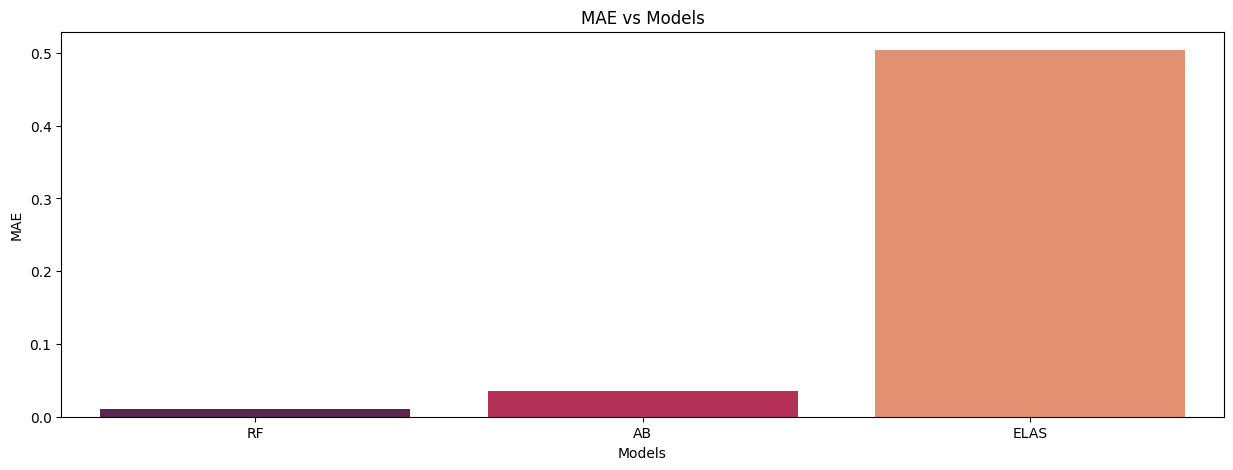

In [224]:
model_msn = [
    ElasticNet(random_state=42),
    RandomForestRegressor(random_state=42),
    AdaBoostRegressor(random_state=42)
]

init_model_msn = basic_train(model_msn, X_train_msn, y_train_msn, False)
opt_model_msn = basic_train(init_model_msn, X_train_msn, y_train_msn, True)

### **Mã cổ phiểu PNJ**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

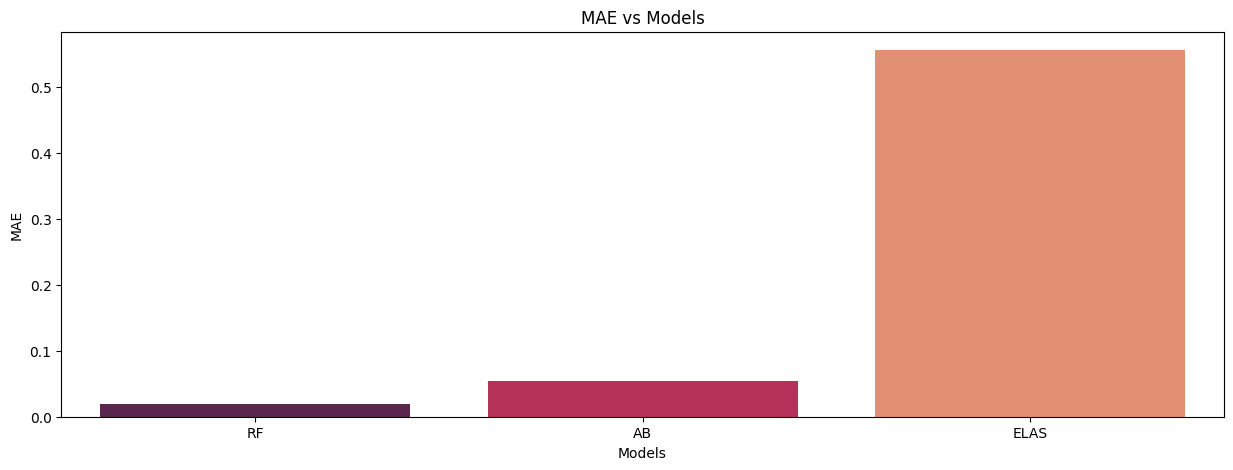

In [225]:
model_pnj = [
    ElasticNet(random_state=42),
    RandomForestRegressor(random_state=42),
    AdaBoostRegressor(random_state=42)
]

init_model_pnj = basic_train(model_pnj, X_train_pnj, y_train_pnj, False)
opt_model_pnj = basic_train(init_model_pnj, X_train_pnj, y_train_pnj, True)

### **Mã cổ phiểu VIC**

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for 

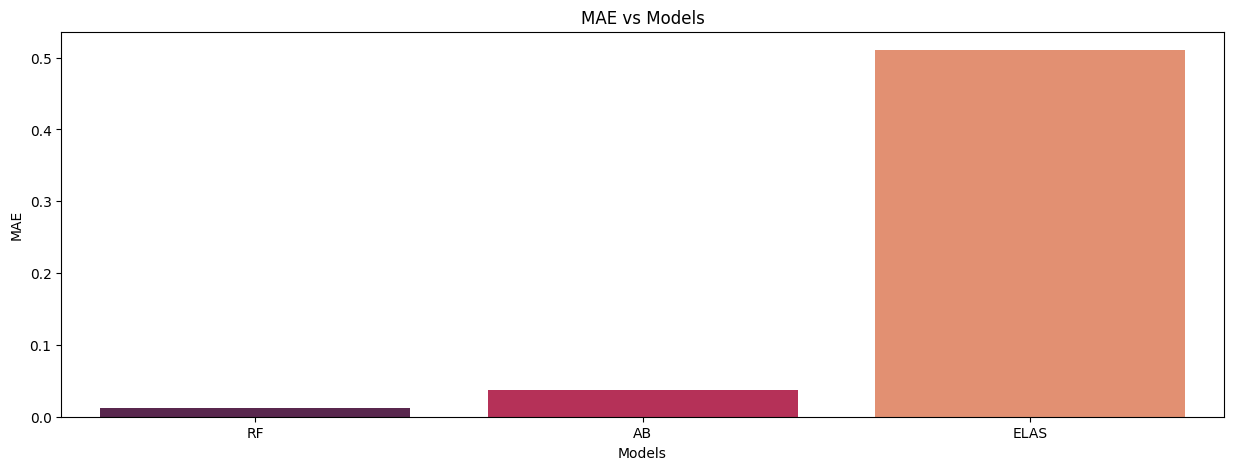

In [228]:
model_vic = [
    ElasticNet(random_state=42),
    RandomForestRegressor(random_state=42),
    AdaBoostRegressor(random_state=42)
]

init_model_vic = basic_train(model_vic, X_train_vic, y_train_vic, False)
opt_model_vic = basic_train(init_model_vic, X_train_vic, y_train_vic, True)

### **Đánh giá sơ bộ**

Mô hình cho kết quả tốt nhất sau khi qua quá trình huấn luyện là mô hình Random Forest, Ada Boost.

## **TESTING**

### **Thử nghiệm trên mã cổ phiếu FPT, sử dụng mô hình Random Forest Regressor**

In [257]:
fpt_real = fpt_scaler_y.inverse_transform(np.array(y_test_fpt[3:]).reshape(-1,1))
fpt_pred = fpt_scaler_y.inverse_transform(one_day_prediction(opt_model_fpt[1], X_test_fpt))

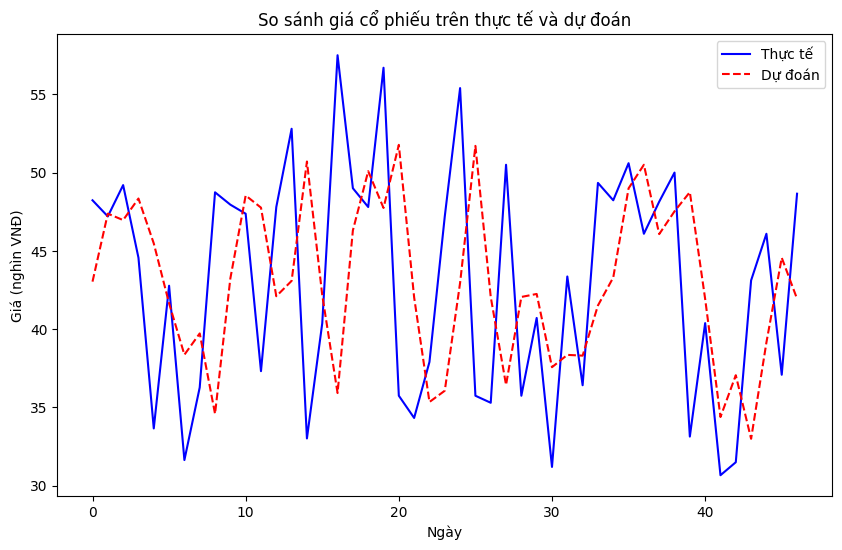

In [258]:
plot_result(fpt_real, fpt_pred)

In [259]:
fpt_real_change = []

for i in range(1, len(fpt_real)):
  fpt_real_change.append((fpt_real[i] - fpt_real[i-1]))

In [260]:
fpt_pred_change = []

for i in range(1, len(fpt_pred)):
  fpt_pred_change.append((fpt_pred[i] - fpt_pred[i-1]))

In [261]:
comp = pd.DataFrame({'Thực tế': fpt_real_change, 'Dự đoán': fpt_pred_change})

In [262]:
comp['Same Direction'] = comp['Thực tế'] * comp['Dự đoán'] > 0

In [263]:
comp['Same Direction'].value_counts()

,count
Same Direction,
False,27
True,19


### **Tạm kết**

Dễ thấy, với phương pháp ước lượng sử dụng Moving Average cho hai giá trị High và Low thì kết quả đầu ra của mô hình chỉ đạt 19/46 ~ 41% cho việc dự đoán đúng xu hướng tăng giảm của giá cổ phiếu. Kết quả này trên thực tế mà nói là không đáng tin cậy để hỗ trợ đầu tư!

Theo bản thân em thì bài toán này có hai khả năng có thể giúp cải thiện độ chính xác của mô hình dự đoán.
- Thứ nhất đó là nếu tiếp tục sử dụng Moving Average, thì nhiều khả năng phải làm nhiễu các giá trị High và Low trong quá trình huấn luyện.
- Thứ hai là dựa trên các dữ liệu thu thập khác, phát triển một mô hình dự đoán chính xác hơn hai giá trị High và Low.

## **LỜI CẢM ƠN**

Qua bài test lần này, em cảm thấy càng tò mò hơn về những yếu tố cần thiết để xây dựng các mô hình dự đoán giúp hỗ trợ người dùng đầu tư một cách hiệu quả.

Thực tế, dù đã làm qua một vài dự án liên quan đến AI nhưng bản thân em vẫn là một người mới trong lĩnh vực này, trong quá trình thực hiện bài test không tránh khỏi được những thiếu sót... Rất mong có cơ hội được gặp mặt, trao đổi cũng như học tập thêm nhiều điều bổ ích từ phía Finpros!